In [12]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

# load general packages
import numpy as np
import time
import copy

import matplotlib.pyplot as plt
# load modules related to this exercise

# load general packages
import numpy as np
# load modules related to this exercise
from model_zucher import zurcher
from Solve_NFXP import solve_NFXP
import estimate_NFXP as estimate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exercise 2

#### 1. Ensure that you understand the code zucher.sim_data

#### 2. Illustrate the likelihood function for different values of RC and c

In [16]:
# Simulate the data

# Set up
model = zurcher()
solver = solve_NFXP()

# update starting value: 
N = 1000
T = 500
ev0 = np.zeros((model.n))
ev,pk = solver.poly(model.bellman, ev0, beta = model.beta, output=2)

# data
data = zurcher.sim_data(model,N,T,pk) 
samplesize = data.shape[0]


In [17]:
# Find tha likelihood value for different combinations 
ev = np.zeros((model.n))
par_RC = copy.copy(model.RC)
par_c = copy.copy(model.c)

NRC = 30
Nc = 20

log_lik = np.nan + np.zeros((NRC,Nc))
RC= np.linspace(8,15,NRC)
c = np.linspace(1,4,Nc)

for i in range(NRC):
    for j in range(Nc):
       
        # STEP 1: Find p 
        tabulate = data.dx1.value_counts()
        p = [tabulate[i]/sum(tabulate) for i in range(tabulate.size-1)]

        # STEP 2: Estimate structual parameters
        model.p = p # Use first step estimates as starting values for t
    
        # Estimate RC and C
        pnames = ['RC','c']
        theta = np.array([RC[i], c[j]])
        log_lik[i,j]=estimate.ll(theta,model, solver,data, pnames, no_guess = True)

log_lik *= samplesize*(-1)

#Re-inset the true parameters 
model.RC = copy.copy(par_RC)
model.c = copy.copy(par_c)

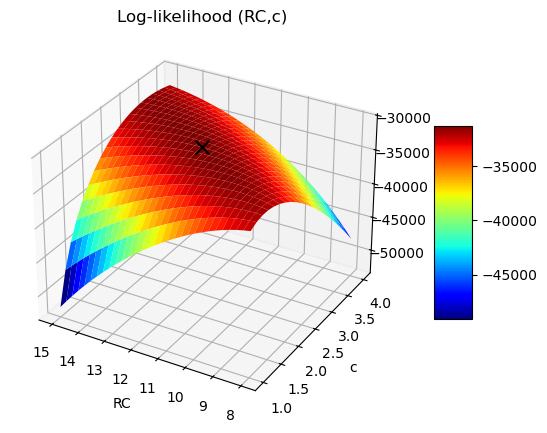

In [21]:
# plot figure in three dimensions
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
# plt.style.use('seaborn-whitegrid')


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1,projection='3d', computed_zorder=False)

# Make data
X, Y = np.meshgrid(RC, c,indexing='ij')
x, y = np.unravel_index(np.argmax(log_lik), log_lik.shape)

# Plot the surface.
surf = ax.plot_surface(X, Y, log_lik, cmap=cm.jet)

#Plot max value
max = ax.scatter(RC[x], c[y], log_lik[x,y], color=['black'], marker='x', s=100)

# Customize the axis.
ax.set_xlabel(f'RC')
ax.set_ylabel(f'c')
ax.set_title(f'Log-likelihood (RC,c)')
ax.invert_xaxis()

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

#### 3. Estimate the model, do you get the correct estimates?
- It does not...?

In [24]:
theta0 = [0,0]
# Estimate
nfxp_model, nfxp_results, pnames, theta_hat, Avar, converged=estimate.estimate(model, solver,data,theta0=theta0)

print(f'Log-Likelihood:     {-nfxp_results.fun*samplesize:.4f}')
print(f'RC:                 {theta_hat[0]:.4f}')
print(f'c:                  {theta_hat[1]:.4f}')

Log-Likelihood:     -531115.6378
RC:                 11.7064
c:                  2.4449


a) Try changing the starting values, does the model converges?
- The model converges in all cases, regardless of the initial guesses for $\textit{RC}$ and $\textit{c}$. The total computation time varies depending on the initial conditions but remains within a reasonable range


In [25]:
#starting values
rc_vec = np.array((0,12))
c_vec = np.array((0, 2, 40))

for i,rc in enumerate(rc_vec):
    for j, c in enumerate(c_vec):
        print(f'starting values: ({rc},{c})')
        t0 = time.time()
        
        # Update start values
        theta0 = [rc, c]
        
        # Estimate
        nfxp_model, nfxp_results, pnames, theta_hat, Avar, converged=estimate.estimate(model, solver,data,theta0=theta0)
        t1 = time.time()
        print(f'RC = {theta_hat[0]:.4f}, c = {theta_hat[1]:.4f}')
        print(f'The model converged: {converged}')
        print(f'Total time = {t1-t0:.4f} \n')
        

starting values: (0,0)
RC = 11.7064, c = 2.4449
The model converged: True
Total time = 3.4972 

starting values: (0,2)
RC = 11.7065, c = 2.4449
The model converged: True
Total time = 2.6842 

starting values: (0,40)
RC = 11.7065, c = 2.4449
The model converged: True
Total time = 7.4786 

starting values: (12,0)
RC = 11.7064, c = 2.4449
The model converged: True
Total time = 12.6763 

starting values: (12,2)
RC = 11.7065, c = 2.4449
The model converged: True
Total time = 5.1480 

starting values: (12,40)
RC = 11.7064, c = 2.4449
The model converged: True
Total time = 9.5396 



#### 4. What happen if you change the maximum number of Newton-Kantorovich iterations and switches between NK and SA to 1? 
Do we get convergence? Do the estimates seem right? 
- In summary, while the model does not converge quickly under the current solver settings, the resulting estimates may not be opttimal as suggested iby the negative value for $c$ and the low log-likelihood. Increasing the number of iterations, adjusting the solver settings, and testing different initial values are recommended to improve the quality of the estimates.

In [29]:
do_settings_solver = {
    'pi_max': 1,
    'max_fxpiter': 1,  
    'printfxp': 1
}

solver = solve_NFXP(**do_settings_solver)
model = zurcher()
nfxp_model, nfxp_results, pnames, theta_hat, Avar, converged=estimate.estimate(model, solver,data,theta0=[0,0])


Begin contraction iterations (for the 1 time)
SA stopped prematurely due to relative tolerance. Start NK iterations
Elapsed time 0.0104 seconds
Begin Newton-Kantorovich iterations (for the 1 time)
N-K converged after 1 iterations, tolerance: 2.728e-12
Elapsed time 0.0049 seconds
Convergence achieved!
Elapsed time: 0.0158 (seconds)
Begin contraction iterations (for the 1 time)
SA converged after 10 iterations, tolerance: 0
Elapsed time 0.0007 seconds
Begin Newton-Kantorovich iterations (for the 1 time)
N-K converged after 1 iterations, tolerance: 0
Elapsed time 0.0012 seconds
Convergence achieved!
Elapsed time: 0.0020 (seconds)
Begin contraction iterations (for the 1 time)
SA converged after 10 iterations, tolerance: 0
Elapsed time 0.0013 seconds
Begin Newton-Kantorovich iterations (for the 1 time)
N-K converged after 1 iterations, tolerance: 0
Elapsed time 0.0010 seconds
Convergence achieved!
Elapsed time: 0.0023 (seconds)
Begin contraction iterations (for the 1 time)
SA stopped premat

In [30]:
print(f'Log-Likelihood:     {-nfxp_results.fun*samplesize:.4f}')
print(f'RC:                 {theta_hat[0]:.4f}')
print(f'c:                  {theta_hat[1]:.4f}')


Log-Likelihood:     -546314.2431
RC:                 3.4434
c:                  -0.3079
